# Install Pyspark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 199 kB 51.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=851207d0df61f619d8bf77bcfe31a7f3014065bcb1b2c6c7442686cd158d4283
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
#!pip install --upgrade --no-cache-dir gdown

In [ ]:
#!gdown --id 1Ba72Gnrjre0KPqhWbQPbyYR3XBguosGf

In [ ]:
#!unzip '/content/last_data.zip' -d '/content/drive/MyDrive/BigData/Data2'

In [ ]:
"""
import json
  
# Opening JSON file
f = open('/content/drive/MyDrive/BigData/part4.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
"""

"\nimport json\n  \n# Opening JSON file\nf = open('/content/drive/MyDrive/BigData/part4.json')\n  \n# returns JSON object as \n# a dictionary\ndata = json.load(f)\n"

# Imports

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession

import json
import itertools
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from itertools import combinations

import requests
import time
import random
from google.colab import files
import pickle
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Create Spark Context and Session

In [ ]:
# Creating spark context
sc = SparkContext()
# Create a spark session
spark = SparkSession.builder.appName('Python Spark Session').getOrCreate()

In [ ]:
# Reading the data and combine all parts in a single RDD
path = '/content/drive/MyDrive/BigData/Data2/*.json'
data_rdd = spark.read.option("multiline","true").json(path).rdd

In [ ]:
# Reading champions and items from the json files into RDDs
champions_rdd = spark.read.json('/content/drive/MyDrive/BigData/champion.json').rdd
items_rdd = spark.read.json('/content/drive/MyDrive/BigData/item.json').rdd

In [ ]:
# Count of obtained Matches
print(f'Total Matches Count: {data_rdd.count()}')

Total Matches Count: 140822


# Ranked Matches

*   **By now, we have matches of different types, but we want only SOLO/DUO RANKED matches.**
*   **After searching, we found that queueID is the variable that defines the type of the match.**

*   **SOLO/DUO RANKED matches have queueID = 420 as obtained from the documentation.**

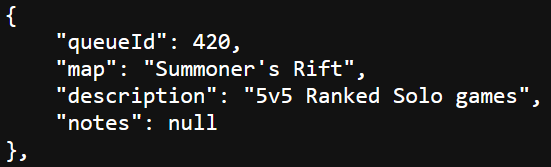

In [ ]:
def ranked_matches(matches):
  """
  Check if the match is SOLO/DUO Ranked or not.
  """
  try:
    if matches["info"]["queueId"]==420:
      return True
  except:
    pass

In [ ]:
ranked_matches_rdd = data_rdd.filter(ranked_matches)

In [ ]:
# number of ranked matchs, teams, participants, bans
ranked_matches_count = ranked_matches_rdd.count()
teams_count = ranked_matches_count*2
participants_count = ranked_matches_count*10

In [ ]:
ranked_matches_count = 52941
teams_count = ranked_matches_count*2
participants_count = ranked_matches_count*10

In [ ]:
print(f'Ranked Matches Count: {ranked_matches_count}')

Ranked Matches Count: 52941


In [ ]:
ranked_matches_rdd.take(1)

[Row(info=Row(gameCreation=1669542249143, gameDuration=2193, gameEndTimestamp=1669544621368, gameId=6235494293, gameMode='CLASSIC', gameName='teambuilder-match-6235494293', gameStartTimestamp=1669542427343, gameType='MATCHED_GAME', gameVersion='12.22.479.5277', mapId=11, participants=[Row(allInPings=0, assistMePings=0, assists=3, baitPings=0, baronKills=1, basicPings=0, bountyLevel=0, challenges=Row(12AssistStreakCount=0, abilityUses=395, acesBefore15Minutes=0, alliedJungleMonsterKills=0.0, baronBuffGoldAdvantageOverThreshold=1, baronTakedowns=1, blastConeOppositeOpponentCount=0, bountyGold=0, buffsStolen=0, completeSupportQuestInTime=0, controlWardTimeCoverageInRiverOrEnemyHalf=0.32091955738188066, controlWardsPlaced=3, damagePerMinute=562.3049421695459, damageTakenOnTeamPercentage=0.25044266404966264, dancedWithRiftHerald=0, deathsByEnemyChamps=8, dodgeSkillShotsSmallWindow=2, doubleAces=0, dragonTakedowns=0, earliestBaron=1469.567502222925, earliestDragonTakedown=None, earliestElder

# Requirement 1
## Champion pick rate, Champion win rate, and Champion ban rate.

### 1.   Champion pick rate: 



*   We firstly found the participants in all Ranked Matches
*   We found the champions assosiated with the participants.
*   We found the count of each champion.
*   Finally, we found the champions pick rates.






In [ ]:
# Get all participants
participants = ranked_matches_rdd.map(lambda x:x['info']['participants']).flatMap(lambda x:x)

In [ ]:
# Get all champions
champions = participants.map(lambda x: x['championName'])

In [ ]:
# Get the count of each champion
champions_pick = champions.map(lambda champion: (champion, 1))
champions_pick_count = champions_pick.reduceByKey(lambda a, b: a + b)

In [ ]:
# Get the the champions pick rates
champions_pick_rate = champions_pick_count.map(lambda x: (x[0], round(x[1]  * 100/ranked_matches_count, 2)))

In [ ]:
print(champions_pick_count.take(10))
print(champions_pick_rate.take(10))

[('Ekko', 5406), ('Zac', 2901), ('Qiyana', 1418), ('Diana', 5755), ('Corki', 724), ('Poppy', 1212), ('Zed', 6964), ('Ziggs', 1437), ('Amumu', 3947), ('Akali', 6141)]
[('Ekko', 10.21), ('Zac', 5.48), ('Qiyana', 2.68), ('Diana', 10.87), ('Corki', 1.37), ('Poppy', 2.29), ('Zed', 13.15), ('Ziggs', 2.71), ('Amumu', 7.46), ('Akali', 11.6)]


In [ ]:
# Output file of champions pick rates
pick_rate = champions_pick_rate.collect()
with open("/content/drive/MyDrive/BigData/Output/champions_pick_rate", "w") as file:
    file.write(str(pick_rate))

In [ ]:
# top 15 picked champions to plot
top_pick_rates = champions_pick_rate.top(15, key=lambda x:x[1])

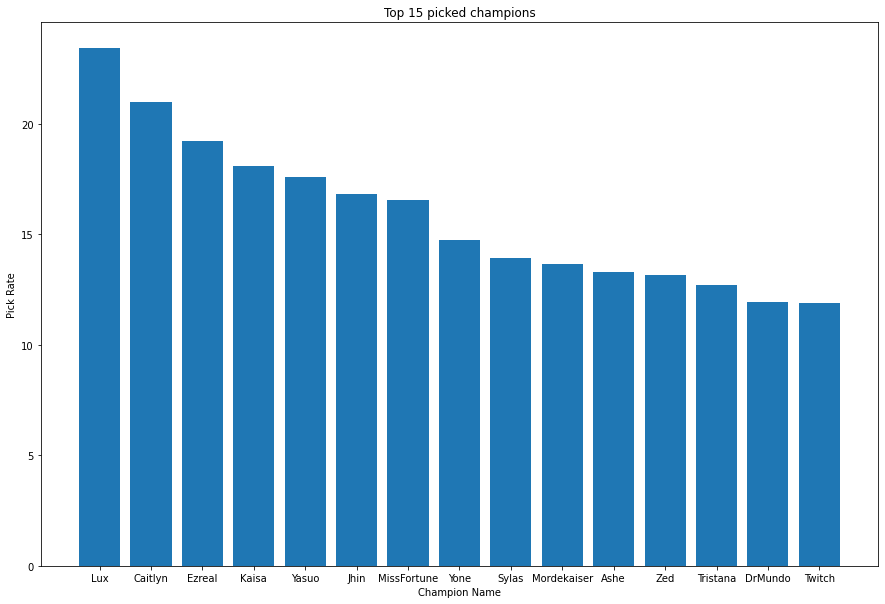

In [ ]:
figure(figsize=(15, 10))
plt.bar(*zip(*top_pick_rates))
plt.title("Top 15 picked champions")
plt.xlabel('Champion Name')
plt.ylabel('Pick Rate')
plt.show()

### 2.   Champion win rate: 



*   We firstly found the participants who winning in all Ranked Matches
*   We found the champions assosiated with the winning participants.
*   We found the count of each winning champion.
*   Finally, we found the champions win rates.



In [ ]:
# Get winning participants
winning_participants = participants.filter(lambda x: x['win'] == True)

In [ ]:
# Get winning champion names
winning_champions_names = winning_participants.map(lambda x: x['championName'])

In [ ]:
# Count the number of times each champion won
winning_champions = winning_champions_names.map(lambda x: (x, 1))
winning_champions_count = winning_champions.reduceByKey(lambda a, b: a + b)

In [ ]:
# Get the champions win rates 
champions_win_rate = winning_champions_count.join(champions_pick_count).mapValues(lambda x:  round(x[0] *100 / x[1], 2))

In [ ]:
print(winning_champions_count.take(10))
print(champions_win_rate.take(10))

[('Ekko', 2764), ('Zac', 1514), ('Qiyana', 688), ('Diana', 2966), ('Corki', 349), ('Poppy', 590), ('Zed', 3363), ('Ziggs', 732), ('Amumu', 2074), ('Leblanc', 885)]
[('Ekko', 51.13), ('Zac', 52.19), ('Qiyana', 48.52), ('Diana', 51.54), ('Corki', 48.2), ('Poppy', 48.68), ('Zed', 48.29), ('Ziggs', 50.94), ('Amumu', 52.55), ('Leblanc', 48.26)]


In [ ]:
# Output file of champions win rates
win_rate = champions_win_rate.collect()
with open("/content/drive/MyDrive/BigData/Output/champions_win_rate", "w") as file:
    file.write(str(win_rate))

In [ ]:
# top 15 winning champions to plot
top_win_rates = champions_win_rate.top(15, key=lambda x:x[1])

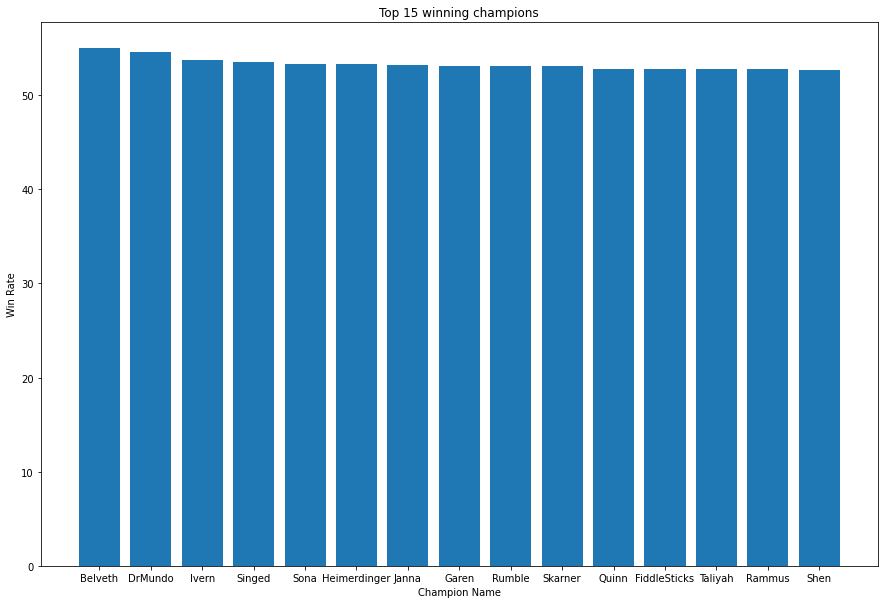

In [ ]:
figure(figsize=(15, 10))
plt.bar(*zip(*top_win_rates))
plt.title("Top 15 winning champions")
plt.xlabel('Champion Name')
plt.ylabel('Win Rate')
plt.show()

### 3.   Champion ban rate: 



*   We firstly found the participated teams in all Ranked Matches
*   We found the teams that were banned.
*   We found the champions IDs associated with the banned participants.
*   Finally, we found the champions ban rates associated with each champion name.



In [ ]:
# Get the teams info
participated_teams = ranked_matches_rdd.map(lambda x:x['info']['teams']).flatMap(lambda x:x)

In [ ]:
# Get all the bans
bans = participated_teams.map(lambda x: x['bans']).flatMap(lambda x:x)

In [ ]:
# Get the ids of banned champions
banned_championsId = bans.map(lambda x: x['championId'])

In [ ]:
# Count the number of times each champion was banned
championsId_ban = banned_championsId.map(lambda champion: (champion, 1))
championsId_ban_count = championsId_ban.reduceByKey(lambda a, b: a + b)

In [ ]:
championsId_ban_count.take(50)

[(56, 1886),
 (112, 1861),
 (57, 390),
 (113, 404),
 (1, 428),
 (897, 4733),
 (114, 10898),
 (58, 1025),
 (2, 1249),
 (115, 215),
 (59, 130),
 (3, 144),
 (60, 996),
 (4, 35),
 (117, 3462),
 (61, 97),
 (5, 303),
 (62, 1311),
 (6, 1056),
 (63, 5087),
 (7, 2328),
 (119, 9680),
 (64, 2049),
 (120, 9838),
 (8, 2414),
 (121, 1345),
 (9, 949),
 (122, 14926),
 (234, 2275),
 (10, 645),
 (11, 17565),
 (235, 2032),
 (67, 4728),
 (68, 128),
 (236, 1659),
 (12, 293),
 (516, 379),
 (517, 6471),
 (69, 1390),
 (13, 90),
 (238, 26261),
 (350, 13291),
 (126, 146),
 (14, 896),
 (518, 308),
 (15, 1108),
 (127, 406),
 (16, 1107),
 (240, 442),
 (72, 62)]

In [ ]:
# Get champion ban rate
championsId_ban_rate = championsId_ban_count.map(lambda x: (x[0], x[1]  * 100/ranked_matches_count))

In [ ]:
# Get the ban rate for each champion name
championsId_ban_rate_list = [list(i) for i in championsId_ban_rate.collect()]
championsName_ban_rate = []
for j in championsId_ban_rate_list:
  if(j[0] != -1):
    name = champions_rdd.map(lambda x: x['data']).flatMap(lambda x:x).filter(lambda x: x['key'] == str(j[0])).map(lambda x: x['name']).collect()[0]
    championsName_ban_rate.append(tuple([name, j[1]]))

In [ ]:
championsName_ban_rate

[('Nocturne', 3.562456319298842),
 ('Viktor', 3.5152339396686876),
 ('Maokai', 0.7366691222304075),
 ('Sejuani', 0.7631136548232939),
 ('Annie', 0.808447139268242),
 ("K'Sante", 8.940140911580816),
 ('Fiora', 20.585179728376872),
 ('Renekton', 1.9361175648363271),
 ('Olaf', 2.3592300863225097),
 ('Ziggs', 0.40611246481932717),
 ('Jarvan IV', 0.24555637407680247),
 ('Galio', 0.2720009066696889),
 ('Elise', 1.8813396044653483),
 ('Twisted Fate', 0.06611133148221605),
 ('Lulu', 6.539355131183771),
 ('Orianna', 0.18322283296499878),
 ('Xin Zhao', 0.5723352411174704),
 ('Wukong', 2.4763415878052926),
 ('Urgot', 1.9946733155777185),
 ('Brand', 9.608809807143802),
 ('LeBlanc', 4.397347991159971),
 ('Draven', 18.284505392795754),
 ('Lee Sin', 3.870346234487448),
 ('Hecarim', 18.58295083205833),
 ('Vladimir', 4.559792977087701),
 ("Kha'Zix", 2.5405640241023026),
 ('FiddleSticks', 1.7925615307606582),
 ('Darius', 28.193649534387337),
 ('Viego', 4.297236546344044),
 ('Kayle', 1.2183373944579816),

In [ ]:
# Output file of champions ban rates
with open("/content/drive/MyDrive/BigData/Output/championsNames_ban_rate", "w") as file:
    file.write(str(championsName_ban_rate))

In [ ]:
# sorted banned champions
sorted_ban_rates = sorted(championsName_ban_rate, key=lambda x: x[1], reverse=True)

In [ ]:
sorted_ban_rates

[('Zed', 49.60427645869931),
 ('Master Yi', 33.17844392814643),
 ('Morgana', 32.116884834060556),
 ('Darius', 28.193649534387337),
 ('Dr. Mundo', 27.81209270697569),
 ('Mordekaiser', 26.70142233807446),
 ('Samira', 25.598307549914054),
 ('Yuumi', 25.105305906575243),
 ('Yasuo', 24.33085888064071),
 ('Udyr', 24.192969532120664),
 ('Blitzcrank', 21.33129332653331),
 ('Shaco', 21.032847887270734),
 ('Fiora', 20.585179728376872),
 ('Akali', 18.737840237245234),
 ('Hecarim', 18.58295083205833),
 ('Draven', 18.284505392795754),
 ('Rammus', 18.229727432424774),
 ('Caitlyn', 17.42128029315653),
 ('Pyke', 17.253168621673183),
 ('Aatrox', 16.9830566101887),
 ("Bel'Veth", 16.397499102774788),
 ('Yone', 15.921497516102832),
 ('Irelia', 14.353714512381709),
 ('Lux', 14.340492246085265),
 ('Teemo', 12.821820517179502),
 ('Twitch', 12.366596777544814),
 ('Sylas', 12.223040743469145),
 ('Kassadin', 10.351145614929827),
 ('Warwick', 9.971477682703387),
 ('Katarina', 9.941255359740088),
 ('Illaoi', 9.87

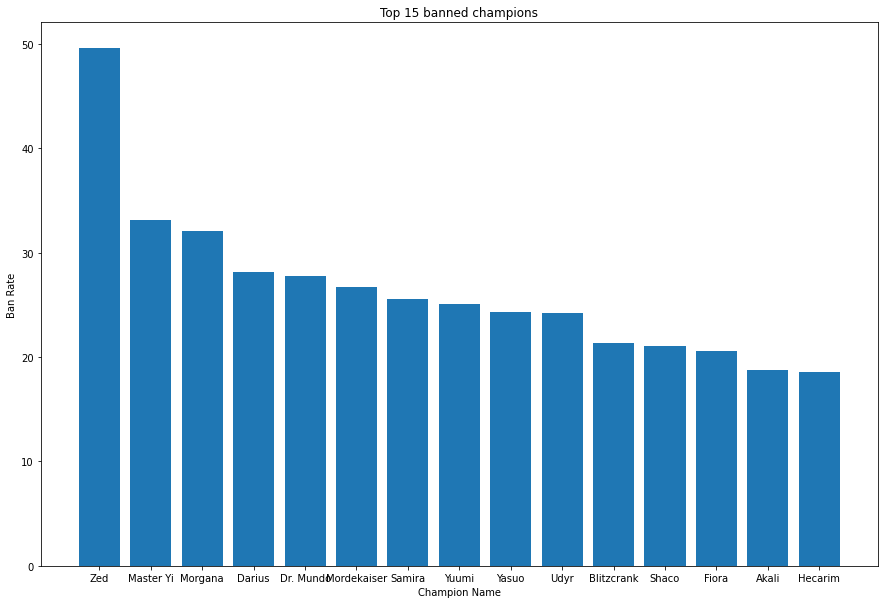

In [ ]:
# top 15 banned champions to plot
top_ban_rates = sorted_ban_rates[:15]
figure(figsize=(15, 10))
plt.bar(*zip(*top_ban_rates))
plt.title("Top 15 banned champions")
plt.xlabel('Champion Name')
plt.ylabel('Ban Rate')
plt.show()

# Requirement 2

## Champion Synergies or duos.
**Champion Synergies or duos** is defined as the number of times 2 champions won together (in the same team) divided by the total number of times these 2 champions played together (same team)

*   We firstly found the participants in all Ranked Matches.
*   We found all possible duos in all ranked matches.
*   We found the count of each possible duos.
*   We found the all winning duos.
*   We found the count of winning duos.
*   Finally, we found the champions synergies by dividing the count that a certian duo won by the number of times that this duo played together.






In [ ]:
def all_champion_duos(matches):
  """
  This function finds all possible duos
  """
  champion_names= []
  count_duos = []
  # Get all participants in all matches
  participants = matches["info"]["participants"]
  # Get the champion names of all winning participants
  for i in participants:
    champion_names.append(i["championName"])
  # Form all possible duos between winning champions
  temp_duos = combinations(champion_names, 2)
  for i in temp_duos:
    count_duos.append((tuple(sorted(i)), 1))

  return count_duos

In [ ]:
def winning_champion_duos(matches):
  """
  This function finds winning duos only
  """
  winning_champion_names= []
  count_winning_duos = []
  # Get all participants in all matches
  participants = matches["info"]["participants"]
  # Get the champion names of all winning participants
  for i in participants:
    if i["win"]:
      winning_champion_names.append(i["championName"])
  # Form all possible duos between winning champions
  temp_winning_duos = combinations(winning_champion_names, 2)
  for i in temp_winning_duos:
    count_winning_duos.append((tuple(sorted(i)), 1))

  return count_winning_duos

In [ ]:
# Get all possible champion duos from all matches
all_duos = ranked_matches_rdd.map(all_champion_duos)

# Get the number of count of each duos champions
all_duos_count = all_duos.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get the winning duos
winning_duos = ranked_matches_rdd.map(winning_champion_duos)

# Get the count of each winning duos
winning_duos_count = winning_duos.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get champion synergies or duos
champions_synergies = winning_duos_count.join(all_duos_count).mapValues(lambda x:  round(x[0] *100 / x[1], 2))

In [ ]:
winning_duos.take(10)

[[(('Aatrox', 'Diana'), 1),
  (('Aatrox', 'Vex'), 1),
  (('Aatrox', 'Yasuo'), 1),
  (('Aatrox', 'Malphite'), 1),
  (('Diana', 'Vex'), 1),
  (('Diana', 'Yasuo'), 1),
  (('Diana', 'Malphite'), 1),
  (('Vex', 'Yasuo'), 1),
  (('Malphite', 'Vex'), 1),
  (('Malphite', 'Yasuo'), 1)],
 [(('Kled', 'Mordekaiser'), 1),
  (('Kled', 'Yasuo'), 1),
  (('Ashe', 'Kled'), 1),
  (('Kled', 'Morgana'), 1),
  (('Mordekaiser', 'Yasuo'), 1),
  (('Ashe', 'Mordekaiser'), 1),
  (('Mordekaiser', 'Morgana'), 1),
  (('Ashe', 'Yasuo'), 1),
  (('Morgana', 'Yasuo'), 1),
  (('Ashe', 'Morgana'), 1)],
 [(('Amumu', 'Karthus'), 1),
  (('Fizz', 'Karthus'), 1),
  (('Caitlyn', 'Karthus'), 1),
  (('Karthus', 'Zed'), 1),
  (('Amumu', 'Fizz'), 1),
  (('Amumu', 'Caitlyn'), 1),
  (('Amumu', 'Zed'), 1),
  (('Caitlyn', 'Fizz'), 1),
  (('Fizz', 'Zed'), 1),
  (('Caitlyn', 'Zed'), 1)],
 [(('Evelynn', 'Irelia'), 1),
  (('Akshan', 'Irelia'), 1),
  (('Ezreal', 'Irelia'), 1),
  (('Irelia', 'Nami'), 1),
  (('Akshan', 'Evelynn'), 1),
  (('E

In [ ]:
all_duos.take(10)

[[(('Aatrox', 'Diana'), 1),
  (('Aatrox', 'Vex'), 1),
  (('Aatrox', 'Yasuo'), 1),
  (('Aatrox', 'Malphite'), 1),
  (('Aatrox', 'Ornn'), 1),
  (('Aatrox', 'Lillia'), 1),
  (('Aatrox', 'Yone'), 1),
  (('Aatrox', 'MissFortune'), 1),
  (('Aatrox', 'Lux'), 1),
  (('Diana', 'Vex'), 1),
  (('Diana', 'Yasuo'), 1),
  (('Diana', 'Malphite'), 1),
  (('Diana', 'Ornn'), 1),
  (('Diana', 'Lillia'), 1),
  (('Diana', 'Yone'), 1),
  (('Diana', 'MissFortune'), 1),
  (('Diana', 'Lux'), 1),
  (('Vex', 'Yasuo'), 1),
  (('Malphite', 'Vex'), 1),
  (('Ornn', 'Vex'), 1),
  (('Lillia', 'Vex'), 1),
  (('Vex', 'Yone'), 1),
  (('MissFortune', 'Vex'), 1),
  (('Lux', 'Vex'), 1),
  (('Malphite', 'Yasuo'), 1),
  (('Ornn', 'Yasuo'), 1),
  (('Lillia', 'Yasuo'), 1),
  (('Yasuo', 'Yone'), 1),
  (('MissFortune', 'Yasuo'), 1),
  (('Lux', 'Yasuo'), 1),
  (('Malphite', 'Ornn'), 1),
  (('Lillia', 'Malphite'), 1),
  (('Malphite', 'Yone'), 1),
  (('Malphite', 'MissFortune'), 1),
  (('Lux', 'Malphite'), 1),
  (('Lillia', 'Ornn'),

In [ ]:
champions_synergies.take(10)

[(('Jax', 'Sejuani'), 22.66),
 (('Malzahar', 'Twitch'), 20.85),
 (('Amumu', 'Twitch'), 22.72),
 (('Lucian', 'Yasuo'), 24.97),
 (('Irelia', 'Varus'), 22.67),
 (('Darius', 'Twitch'), 25.5),
 (('Kaisa', 'Zyra'), 19.92),
 (('Jayce', 'Thresh'), 16.67),
 (('Seraphine', 'Ziggs'), 19.18),
 (('Hecarim', 'Malzahar'), 26.95)]

In [ ]:
# Output file of champions win rates
champions_duos = champions_synergies.collect()
with open("/content/drive/MyDrive/BigData/Output/champions_synergies", "w") as file:
    file.write(str(champions_duos))

In [ ]:
# top 15 winning champions to plot
top_duos = champions_synergies.top(15, key=lambda x:x[1])

In [ ]:
top_duos

[(('AurelionSol', 'Cassiopeia'), 100.0),
 (('Corki', 'Ivern'), 100.0),
 (('AurelionSol', 'Braum'), 100.0),
 (('Akshan', 'AurelionSol'), 100.0),
 (('Ivern', 'Kled'), 85.71),
 (('AurelionSol', 'Kindred'), 83.33),
 (('Ivern', 'Rumble'), 80.0),
 (('KogMaw', 'Skarner'), 80.0),
 (('Ivern', 'Ziggs'), 77.78),
 (('Quinn', 'Taliyah'), 75.0),
 (('AurelionSol', 'Neeko'), 66.67),
 (('Ivern', 'Maokai'), 66.67),
 (('Braum', 'Ivern'), 66.67),
 (('Kennen', 'RekSai'), 66.67),
 (('Chogath', 'Ivern'), 60.0)]

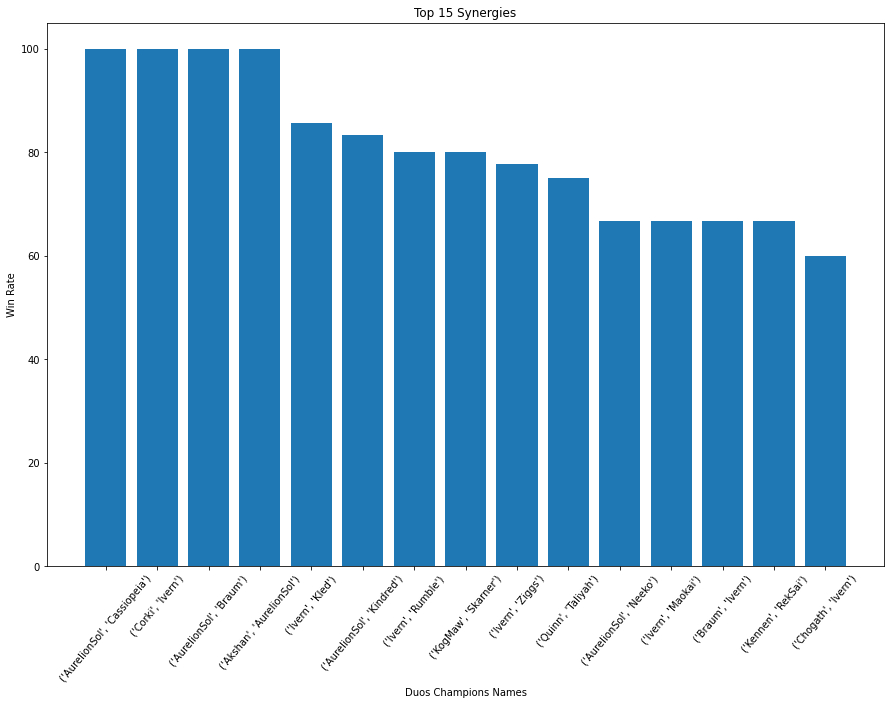

In [ ]:
a,b=zip(*top_duos)
duos=[]
for i in a:
  duos.append(str(i))
plt.figure(figsize=(15, 10));
plt.xticks(rotation=50)
plt.title("Top 15 Synergies")
plt.xlabel('Duos Champions Names')
plt.ylabel('Win Rate')
plt.bar(duos,b);

# Requirement 3
## Item win, pick rates.

### 1.   Item pick rate: 



*   We firstly found the participants in all Ranked Matches
*   We found the items associated with the participants.
*   We found the count of each item.
*   Finally, we found the items pick rates.




In [ ]:
# Get all participants
participants = ranked_matches_rdd.map(lambda x:x['info']['participants']).flatMap(lambda x:x)

In [ ]:
# Get all items bought by all participants
items = participants.map(lambda x: [x['item0'], x['item1'], x['item2'], x['item3'], x['item4'], x['item5']]).flatMap(lambda x: x)

In [ ]:
# Get the count of each item
items_pick = items.map(lambda item: (item, 1))
items_pick_count = items_pick.reduceByKey(lambda a, b: a + b)

In [ ]:
# Get the the items pick rates
items_pick_rate = items_pick_count.map(lambda x: (x[0], round(x[1]  * 100/participants_count, 2)))

In [ ]:
print(items_pick_count.take(10))
print(items_pick_rate.take(10))

[(0, 356335), (3864, 6008), (6664, 2288), (3024, 3874), (7000, 81), (6665, 24551), (3193, 4099), (6609, 3819), (7001, 153), (3082, 6459)]
[(0, 67.31), (3864, 1.13), (6664, 0.43), (3024, 0.73), (7000, 0.02), (6665, 4.64), (3193, 0.77), (6609, 0.72), (7001, 0.03), (3082, 1.22)]


In [ ]:
# Get the pick rate for each item name
itemsId_pick_rate_list = [list(i) for i in items_pick_rate.collect()]
itemsName_pick_rate = []
for j in itemsId_pick_rate_list:
  try:
     name = items_rdd.map(lambda x: x['data'][str(j[0])]['name'] ).collect()[0]
     itemsName_pick_rate.append(tuple([name, j[1]]))
  except:
    pass

In [ ]:
itemsName_pick_rate

[('Black Mist Scythe', 1.13),
 ('Turbo Chemtank', 0.43),
 ('Glacial Buckler', 0.73),
 ("Sandshrike's Claw", 0.02),
 ("Jak'Sho, The Protean", 4.64),
 ('Gargoyle Stoneplate', 0.77),
 ('Chempunk Chainsword', 0.72),
 ('Syzygy', 0.03),
 ("Warden's Mail", 1.22),
 ('Guardian Angel', 1.95),
 ("Draktharr's Shadowcarver", 0.02),
 ("Warmog's Armor", 0.49),
 ("Giant's Belt", 3.5),
 ('Radiant Virtue', 0.63),
 ('Mercurial Scimitar', 0.22),
 ('Heartsteel', 3.47),
 ('Quicksilver Sash', 0.3),
 ("Death's Dance", 6.27),
 ("Runaan's Hurricane", 1.35),
 ('Frozen Fist', 0.03),
 ("Youmuu's Ghostblade", 1.89),
 ('Noonquiver', 0.68),
 ('Zeal', 1.61),
 ('Edge of Night', 0.96),
 ('Typhoon', 0.04),
 ('Infinity Edge', 7.18),
 ('Wyrmfallen Sacrifice', 0.08),
 ('Galeforce', 4.83),
 ("Randuin's Omen", 0.88),
 ('Bloodward', 0.05),
 ('Kraken Slayer', 10.26),
 ('Staff of Flowing Water', 0.64),
 ("Rabadon's Deathcap", 5.37),
 ('Immortal Shieldbow', 6.46),
 ('Mortal Reminder', 2.57),
 ('Moonstone Renewer', 1.57),
 ('Hexte

In [ ]:
# Output file of champions ban rates
with open("/content/drive/MyDrive/BigData/Output/itemsNames_pick_rate", "w") as file:
    file.write(str(itemsName_pick_rate))

In [ ]:
# sorted banned champions
sorted_items_pick_rates = sorted(itemsName_pick_rate, key=lambda x: x[1], reverse=True)

In [ ]:
sorted_items_pick_rates

[("Sorcerer's Shoes", 21.37),
 ("Berserker's Greaves", 20.8),
 ('Plated Steelcaps', 19.33),
 ('Ionian Boots of Lucidity', 14.07),
 ('Shard of True Ice', 11.21),
 ("Mercury's Treads", 10.55),
 ("Zhonya's Hourglass", 10.41),
 ('Kraken Slayer', 10.26),
 ('Blade of The Ruined King', 9.77),
 ('Long Sword', 9.29),
 ("Doran's Blade", 9.18),
 ('Control Ward', 8.14),
 ("Luden's Tempest", 7.74),
 ('Shadowflame', 7.39),
 ("Liandry's Anguish", 7.23),
 ('Infinity Edge', 7.18),
 ('The Collector', 7.01),
 ('Refillable Potion', 6.99),
 ('Ravenous Hydra', 6.84),
 ('Immortal Shieldbow', 6.46),
 ("Death's Dance", 6.27),
 ('Thornmail', 5.64),
 ('Amplifying Tome', 5.61),
 ("Lord Dominik's Regards", 5.53),
 ("Caulfield's Warhammer", 5.44),
 ("Rabadon's Deathcap", 5.37),
 ('Needlessly Large Rod', 5.35),
 ('Divine Sunderer', 5.28),
 ('Ruby Crystal', 5.16),
 ('Eclipse', 4.9),
 ('Galeforce', 4.83),
 ('Cloak of Agility', 4.71),
 ('Demonic Embrace', 4.67),
 ("Jak'Sho, The Protean", 4.64),
 ("Doran's Ring", 4.63),

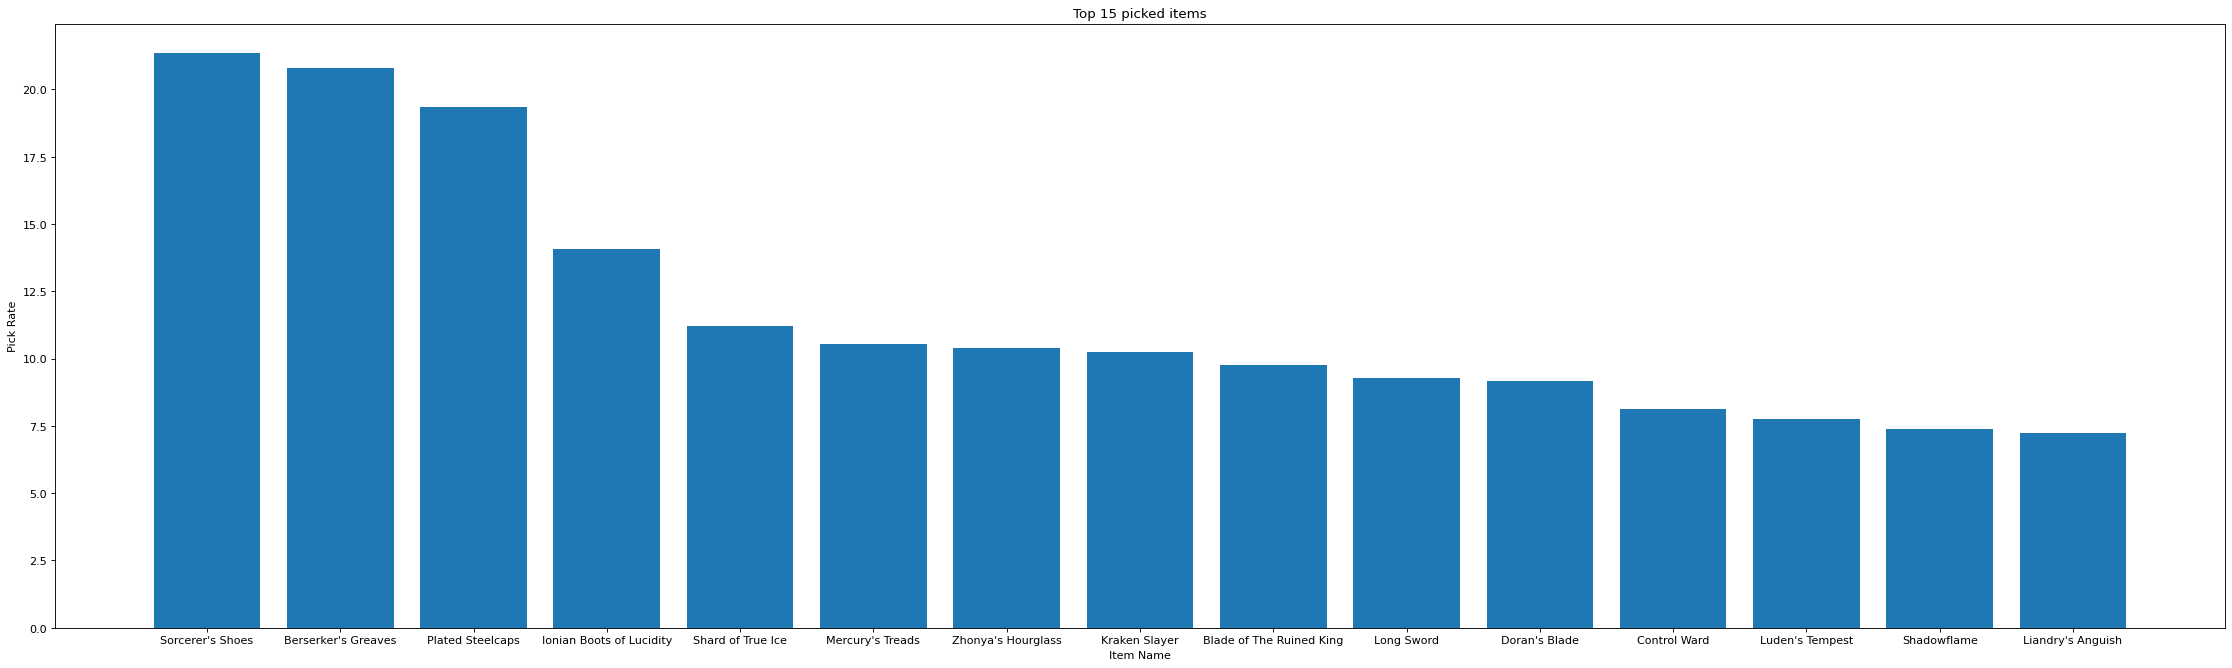

In [ ]:
# top 15 picked items to plot
top_items_pick_rates = sorted_items_pick_rates[:15]
figure(figsize=(35, 10), dpi=80)
plt.bar(*zip(*top_items_pick_rates))
plt.title("Top 15 picked items")
plt.xlabel('Item Name')
plt.ylabel('Pick Rate')
plt.show()

### 2.   Item win rate: 



*   We firstly found the participants who winning in all Ranked Matches
*   We found the items assosiated with the winning participants.
*   We found the count of each winning item.
*   Finally, we found the items win rates.



In [ ]:
# Get winning participants
winning_participants = participants.filter(lambda x: x['win'] == True)

In [ ]:
# Get all items bought by winning participants
winning_items = winning_participants.map(lambda x: [x['item0'], x['item1'], x['item2'], x['item3'], x['item4'], x['item5']]).flatMap(lambda x: x)

In [ ]:
# Get the count of each item
items_win = winning_items.map(lambda item: (item, 1))
items_win_count = items_win.reduceByKey(lambda a, b: a + b)

In [ ]:
# Get the the items pick rates
items_win_rate = items_win_count.join(items_pick_count).mapValues(lambda x: round(x[0] *100 / x[1], 2))

In [ ]:
print(items_win_count.take(10))
print(items_win_rate.take(10))

[(0, 155706), (3864, 3016), (3024, 1855), (6664, 1256), (7000, 69), (6665, 13061), (3193, 2350), (6609, 1934), (7001, 96), (3082, 3154)]
[(0, 43.7), (3864, 50.2), (3024, 47.88), (6664, 54.9), (7000, 85.19), (6665, 53.2), (3193, 57.33), (6609, 50.64), (7001, 62.75), (3082, 48.83)]


In [ ]:
# Get the win rate for each item name
itemsId_win_rate_list = [list(i) for i in items_win_rate.collect()]
itemsName_win_rate = []
for j in itemsId_win_rate_list:
  try:
     name = items_rdd.map(lambda x: x['data'][str(j[0])]['name'] ).collect()[0]
     itemsName_win_rate.append(tuple([name, j[1]]))
  except:
    pass

In [ ]:
itemsName_win_rate

[('Black Mist Scythe', 50.2),
 ('Glacial Buckler', 47.88),
 ('Turbo Chemtank', 54.9),
 ("Sandshrike's Claw", 85.19),
 ("Jak'Sho, The Protean", 53.2),
 ('Gargoyle Stoneplate', 57.33),
 ('Chempunk Chainsword', 50.64),
 ('Syzygy', 62.75),
 ("Warden's Mail", 48.83),
 ('Guardian Angel', 61.96),
 ("Draktharr's Shadowcarver", 60.71),
 ("Giant's Belt", 47.5),
 ('Radiant Virtue', 53.79),
 ("Warmog's Armor", 57.57),
 ('Mercurial Scimitar', 57.3),
 ('Heartsteel', 52.49),
 ('Quicksilver Sash', 51.93),
 ("Death's Dance", 56.74),
 ("Runaan's Hurricane", 55.15),
 ('Frozen Fist', 59.21),
 ("Youmuu's Ghostblade", 52.78),
 ('Zeal', 47.28),
 ('Edge of Night', 55.33),
 ('Noonquiver', 29.22),
 ('Typhoon', 62.0),
 ('Infinity Edge', 58.36),
 ('Galeforce', 50.98),
 ("Randuin's Omen", 53.06),
 ('Wyrmfallen Sacrifice', 59.3),
 ('Kraken Slayer', 50.88),
 ('Staff of Flowing Water', 57.47),
 ('Bloodward', 65.32),
 ("Rabadon's Deathcap", 58.98),
 ('Immortal Shieldbow', 51.77),
 ('Mortal Reminder', 52.66),
 ('Moonst

In [ ]:
# Output file of champions ban rates
with open("/content/drive/MyDrive/BigData/Output/itemsName_win_rate", "w") as file:
    file.write(str(itemsName_win_rate))

In [ ]:
# sorted banned champions
sorted_items_win_rates = sorted(itemsName_win_rate, key=lambda x: x[1], reverse=True)

In [ ]:
sorted_items_win_rates

[("Sandshrike's Claw", 85.19),
 ('Equinox', 82.35),
 ("Mejai's Soulstealer", 76.62),
 ("Icathia's Curse", 70.83),
 ('Infinity Force', 70.69),
 ('Your Cut', 70.1),
 ('Vespertide', 67.5),
 ('Primordial Dawn', 66.67),
 ('Deicide', 65.98),
 ('Starcaster', 65.96),
 ('Reliquary of the Golden Dawn', 65.79),
 ('Vigilant Wardstone', 65.36),
 ('Bloodward', 65.32),
 ('Eye of Luden', 64.69),
 ('Upgraded Aeropack', 64.38),
 ('Caesura', 63.41),
 ('Syzygy', 62.75),
 ("Shurelya's Requiem", 62.3),
 ('Typhoon', 62.0),
 ('Guardian Angel', 61.96),
 ("Liandry's Lament", 61.93),
 ('Elixir of Iron', 61.54),
 ('Seat of Command', 61.22),
 ("Draktharr's Shadowcarver", 60.71),
 ('Abyssal Mask', 60.57),
 ('Spear Of Shojin', 60.48),
 ("Knight's Vow", 60.17),
 ('Ceaseless Hunger', 60.0),
 ('Redemption', 59.31),
 ('Wyrmfallen Sacrifice', 59.3),
 ('Leviathan', 59.26),
 ("Sterak's Gage", 59.24),
 ('Frozen Fist', 59.21),
 ('Titanic Hydra', 59.16),
 ("Rabadon's Deathcap", 58.98),
 ('Bloodthirster', 58.78),
 ('Infinity E

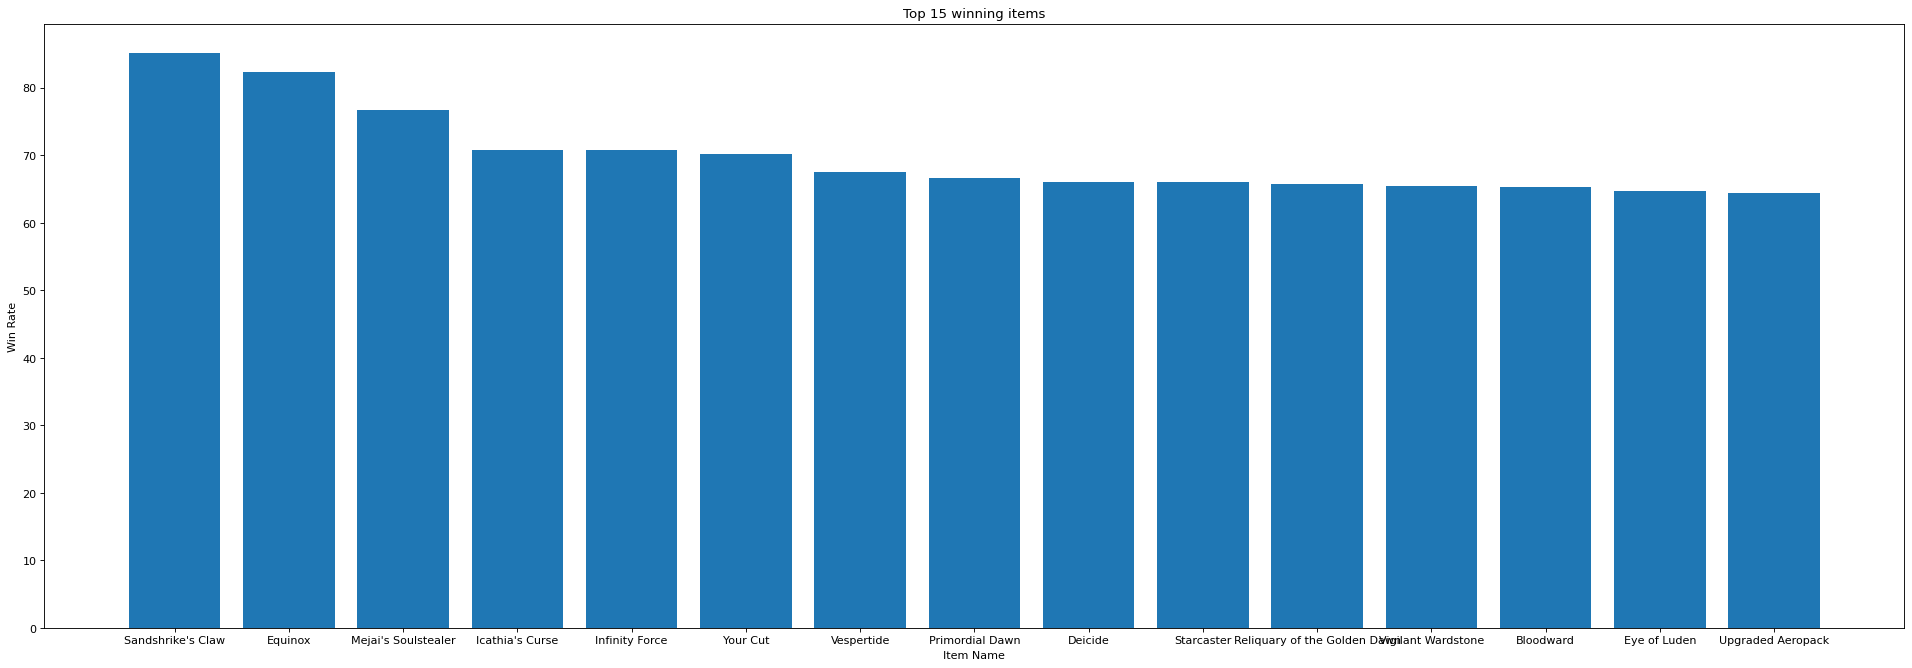

In [ ]:
# top 15 picked items to plot
top_items_win_rates = sorted_items_win_rates[:15]
figure(figsize=(30, 10), dpi=80)
plt.bar(*zip(*top_items_win_rates))
plt.title("Top 15 winning items")
plt.xlabel('Item Name')
plt.ylabel('Win Rate')
plt.show()

# Requirement 4
## Item Synergies (item with champion, item with class) 


### 1.   Item with champion Synergy: 







In [ ]:
def all_champion_items_duos(matches):
  """
  This function finds all possible champions items duos
  """
  champion_items= []
  champions_items_duos = []

  # Get all participants in all matches
  participants = matches["info"]["participants"]

  # Get the champion names of all participants
  for i in participants:
    for k in range(6):
      if i["item"+str(k)] !=0:
        champion_items.append(tuple([ i["championName"], i['item'+str(k)]] ))

  # Form all possible duos between champions and items
  for i in champion_items:
      champions_items_duos.append((i, 1))
  
  return champions_items_duos

In [ ]:
def winning_champion_items_duos(matches):
  """
  This function finds winning duos only
  """
  winning_champion_items= []
  winning_champions_items_duos = []
  # Get all participants in all matches
  participants = matches["info"]["participants"]
  # Get the champion names of all winning participants
  for i in participants:
    if i["win"]:
      for k in range(6):
        if i["item"+str(k)] !=0:
          winning_champion_items.append(tuple([ i["championName"], i['item'+str(k)]] ))

  # Form all possible duos between winning champions and items
  for i in winning_champion_items:
      winning_champions_items_duos.append((i, 1))
  
  return winning_champions_items_duos

In [ ]:
# Get all possible champion items duos from all matches
all_champion_items_duos = ranked_matches_rdd.map(all_champion_items_duos)

# Get the number of count of each duos champions
all_champion_items_duos_count = all_champion_items_duos.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get the winning champion items duos
winning_champion_items_duos = ranked_matches_rdd.map(winning_champion_items_duos)

# Get the count of each winning duos
winning_champion_items_duos_count = winning_champion_items_duos.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get champion synergies or duos
champions_items_synergies = winning_champion_items_duos_count.join(all_champion_items_duos_count).mapValues(lambda x: round(x[0] *100 / x[1], 2))

In [ ]:
all_champion_items_duos_count.take(50)

[(('Zed', 2031), 1205),
 (('Zed', 3047), 828),
 (('MasterYi', 3857), 4),
 (('Caitlyn', 3026), 379),
 (('Irelia', 3047), 2552),
 (('Ezreal', 3110), 917),
 (('Jax', 3047), 2327),
 (('Twitch', 6672), 2605),
 (('Trundle', 6632), 1484),
 (('Malphite', 3111), 569),
 (('Varus', 4635), 140),
 (('Illaoi', 3193), 39),
 (('Graves', 3133), 411),
 (('Senna', 3094), 1535),
 (('MonkeyKing', 6632), 2283),
 (('Garen', 3047), 1035),
 (('Nami', 2010), 62),
 (('Viego', 3156), 403),
 (('Talon', 3071), 394),
 (('LeeSin', 3134), 126),
 (('FiddleSticks', 3157), 1677),
 (('Leona', 3024), 258),
 (('Jayce', 3070), 141),
 (('Brand', 3116), 1724),
 (('Kayn', 3142), 888),
 (('Ekko', 1054), 9),
 (('Teemo', 1018), 25),
 (('Veigar', 1058), 1016),
 (('Varus', 3051), 136),
 (('TwistedFate', 3094), 581),
 (('Evelynn', 3102), 250),
 (('Vladimir', 4645), 483),
 (('Jayce', 3158), 628),
 (('Fiora', 3156), 389),
 (('Lucian', 3026), 255),
 (('Seraphine', 2003), 94),
 (('Gnar', 1037), 87),
 (('Lissandra', 3157), 626),
 (('Vi', 

In [ ]:
winning_champion_items_duos_count.take(50)

[(('Caitlyn', 3026), 256),
 (('Irelia', 3047), 1270),
 (('Ezreal', 3110), 485),
 (('Jax', 3047), 1179),
 (('Trundle', 6632), 756),
 (('Malphite', 3111), 255),
 (('Twitch', 6672), 1353),
 (('Illaoi', 3193), 16),
 (('MonkeyKing', 6632), 1207),
 (('Garen', 3047), 550),
 (('Senna', 3094), 857),
 (('Nami', 2010), 24),
 (('FiddleSticks', 3157), 926),
 (('Leona', 3024), 144),
 (('Kayn', 3142), 479),
 (('Ekko', 1054), 9),
 (('Veigar', 1058), 469),
 (('Evelynn', 3102), 136),
 (('Vladimir', 4645), 270),
 (('Jayce', 3158), 267),
 (('Fiora', 3156), 223),
 (('Lucian', 3026), 142),
 (('Brand', 3116), 1019),
 (('Lissandra', 3157), 334),
 (('Cassiopeia', 2420), 30),
 (('Zed', 2031), 558),
 (('TwistedFate', 3094), 301),
 (('Zilean', 1033), 6),
 (('Zed', 3143), 5),
 (('Jayce', 3070), 35),
 (('Graves', 3077), 14),
 (('Kayn', 3134), 154),
 (('Seraphine', 2003), 43),
 (('Seraphine', 3107), 21),
 (('Katarina', 1042), 18),
 (('Tristana', 3033), 232),
 (('Aphelios', 1042), 27),
 (('Sona', 3850), 44),
 (('Belv

In [ ]:
champions_items_synergies.take(50)

[(('Caitlyn', 3026), 67.55),
 (('Irelia', 3047), 49.76),
 (('Ezreal', 3110), 52.89),
 (('Jax', 3047), 50.67),
 (('Trundle', 6632), 50.94),
 (('Malphite', 3111), 44.82),
 (('Twitch', 6672), 51.94),
 (('Illaoi', 3193), 41.03),
 (('MonkeyKing', 6632), 52.87),
 (('Garen', 3047), 53.14),
 (('Senna', 3094), 55.83),
 (('Nami', 2010), 38.71),
 (('FiddleSticks', 3157), 55.22),
 (('Leona', 3024), 55.81),
 (('Kayn', 3142), 53.94),
 (('Ekko', 1054), 100.0),
 (('Veigar', 1058), 46.16),
 (('Evelynn', 3102), 54.4),
 (('Vladimir', 4645), 55.9),
 (('Jayce', 3158), 42.52),
 (('Fiora', 3156), 57.33),
 (('Lucian', 3026), 55.69),
 (('Brand', 3116), 59.11),
 (('Lissandra', 3157), 53.35),
 (('Cassiopeia', 2420), 63.83),
 (('Zed', 2031), 46.31),
 (('TwistedFate', 3094), 51.81),
 (('Zilean', 1033), 42.86),
 (('Zed', 3143), 83.33),
 (('Jayce', 3070), 24.82),
 (('Graves', 3077), 32.56),
 (('Kayn', 3134), 43.14),
 (('Seraphine', 2003), 45.74),
 (('Seraphine', 3107), 58.33),
 (('Katarina', 1042), 25.35),
 (('Trist

In [ ]:
# Get the pick rate for each item name
itemsId_duos_list = [list(i) for i in champions_items_synergies.collect()]
itemsName_duos = []
for j in itemsId_duos_list:
  try:
    name = items_rdd.map(lambda x: x['data'][str(j[0][1])]['name'] ).collect()[0]
    itemsName_duos.append([tuple([j[0][0], name]), j[1]])
  except:
    pass

In [ ]:
itemsName_duos

In [ ]:
# Output file of champions ban rates
with open("/content/drive/MyDrive/BigData/Output/itemsName_champions_duos", "w") as file:
    file.write(str(champions_items_synergies.collect()))

In [ ]:
# sorted banned champions
top_items_champions_duos = champions_items_synergies.top(5, key=lambda x:x[1])

In [ ]:
top_items_champions_duos.take(5)

In [ ]:
figure(figsize=(15, 10))
plt.bar(*zip(*top_items_champions_duos))
plt.title("Top 5 champions items duos")
plt.xlabel('Champion-Item Name')
plt.ylabel('Win Rate')
plt.show()

In [ ]:
print(list(top_items_champions_duos))

[(('Ekko', 1054), 100.0), (('Talon', 6671), 100.0), (('Seraphine', 3155), 100.0), (('Teemo', 3026), 100.0), (('Seraphine', 3179), 100.0)]


In [ ]:
top_items_champions_duosss = [(('Ekko', "Doran's Shield"), 100.0), (('Talon', "Galeforce"), 100.0), (('Seraphine', "Hexdrinker"), 100.0), (('Teemo', "Guardian Angel"), 100.0), (('Seraphine', "Umbral Glaive"), 100.0)]

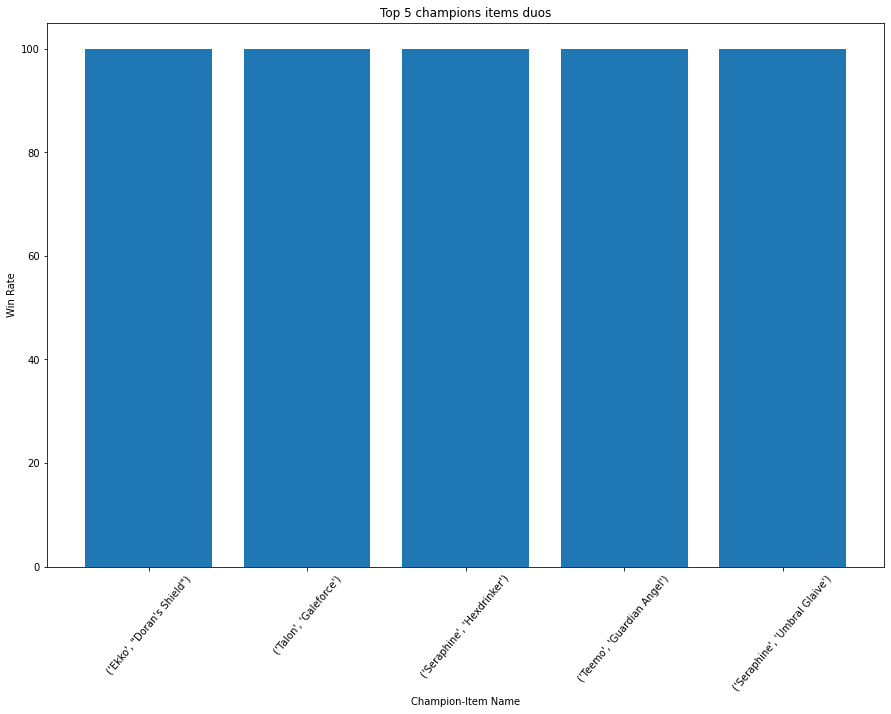

In [ ]:
a,b=zip(*list(top_items_champions_duosss))
duos=[]
for i in a:
  duos.append(str(i))
plt.figure(figsize=(15, 10));
plt.xticks(rotation=50)
plt.title("Top 5 champions items duos")
plt.xlabel('Champion-Item Name')
plt.ylabel('Win Rate')
plt.bar(duos,b);

### 2.   Item with class Synergy: 







In [ ]:
def all_class_items_duos(matches):
  """
  This function finds all possible champions items duos
  """
  class_items= []
  class_items_duos = []

  # Get all participants in all matches
  participants = matches["info"]["participants"]

  # Get the champion names of all participants
  for i in participants:
    for k in range(6):
      if i["item"+str(k)] !=0:
        class_items.append(tuple([ i["lane"], i['item'+str(k)]] ))

  # Form all possible duos between champions and items
  for i in class_items:
      class_items_duos.append((i, 1))
  
  return class_items_duos

In [ ]:
def winning_class_items_duos(matches):
  """
  This function finds winning duos only
  """
  winning_class_items= []
  winning_class_items_duos = []
  # Get all participants in all matches
  participants = matches["info"]["participants"]
  # Get the champion names of all winning participants
  for i in participants:
    if i["win"]:
      for k in range(6):
        if i["item"+str(k)] !=0:
          winning_class_items.append(tuple([ i["lane"], i['item'+str(k)]] ))

  # Form all possible duos between winning champions and items
  for i in winning_class_items:
      winning_class_items_duos.append((i, 1))
  
  return winning_class_items_duos

In [ ]:
# Get all possible champion items duos from all matches
all_class_items_duos = ranked_matches_rdd.map(all_class_items_duos)

# Get the number of count of each duos champions
all_class_items_duos_count = all_class_items_duos.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get the winning champion items duos
winning_class_items_duoss = ranked_matches_rdd.map(winning_class_items_duos)

# Get the count of each winning duos
winning_class_items_duos_count = winning_class_items_duoss.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get champion synergies or duos
class_items_synergies = winning_class_items_duos_count.join(all_class_items_duos_count).mapValues(lambda x: round(x[0] *100 / x[1], 2))

In [ ]:
winning_class_items_duoss.take(10)

[[(('JUNGLE', 6333), 1),
  (('JUNGLE', 6692), 1),
  (('JUNGLE', 3035), 1),
  (('JUNGLE', 3071), 1),
  (('JUNGLE', 3047), 1),
  (('JUNGLE', 3152), 1),
  (('JUNGLE', 3157), 1),
  (('JUNGLE', 3089), 1),
  (('JUNGLE', 4645), 1),
  (('JUNGLE', 3020), 1),
  (('JUNGLE', 3102), 1),
  (('MIDDLE', 3135), 1),
  (('MIDDLE', 3157), 1),
  (('MIDDLE', 6653), 1),
  (('MIDDLE', 3020), 1),
  (('MIDDLE', 4645), 1),
  (('MIDDLE', 1058), 1),
  (('BOTTOM', 3006), 1),
  (('BOTTOM', 2420), 1),
  (('BOTTOM', 6673), 1),
  (('BOTTOM', 6333), 1),
  (('BOTTOM', 1031), 1),
  (('BOTTOM', 3153), 1),
  (('BOTTOM', 3853), 1),
  (('BOTTOM', 4645), 1),
  (('BOTTOM', 4630), 1),
  (('BOTTOM', 6655), 1),
  (('BOTTOM', 3020), 1)],
 [(('JUNGLE', 3074), 1),
  (('JUNGLE', 6692), 1),
  (('JUNGLE', 3047), 1),
  (('JUNGLE', 3068), 1),
  (('JUNGLE', 3153), 1),
  (('JUNGLE', 4633), 1),
  (('JUNGLE', 2421), 1),
  (('JUNGLE', 3047), 1),
  (('JUNGLE', 3065), 1),
  (('JUNGLE', 3116), 1),
  (('JUNGLE', 4637), 1),
  (('MIDDLE', 3072), 1),

In [ ]:
all_class_items_duos.take(10)

[[(('JUNGLE', 6333), 1),
  (('JUNGLE', 6692), 1),
  (('JUNGLE', 3035), 1),
  (('JUNGLE', 3071), 1),
  (('JUNGLE', 3047), 1),
  (('JUNGLE', 3152), 1),
  (('JUNGLE', 3157), 1),
  (('JUNGLE', 3089), 1),
  (('JUNGLE', 4645), 1),
  (('JUNGLE', 3020), 1),
  (('JUNGLE', 3102), 1),
  (('MIDDLE', 3135), 1),
  (('MIDDLE', 3157), 1),
  (('MIDDLE', 6653), 1),
  (('MIDDLE', 3020), 1),
  (('MIDDLE', 4645), 1),
  (('MIDDLE', 1058), 1),
  (('BOTTOM', 3006), 1),
  (('BOTTOM', 2420), 1),
  (('BOTTOM', 6673), 1),
  (('BOTTOM', 6333), 1),
  (('BOTTOM', 1031), 1),
  (('BOTTOM', 3153), 1),
  (('BOTTOM', 3853), 1),
  (('BOTTOM', 4645), 1),
  (('BOTTOM', 4630), 1),
  (('BOTTOM', 6655), 1),
  (('BOTTOM', 3020), 1),
  (('TOP', 3068), 1),
  (('TOP', 7025), 1),
  (('TOP', 4401), 1),
  (('TOP', 3047), 1),
  (('TOP', 3075), 1),
  (('TOP', 1029), 1),
  (('JUNGLE', 3158), 1),
  (('JUNGLE', 3157), 1),
  (('JUNGLE', 3105), 1),
  (('JUNGLE', 4401), 1),
  (('JUNGLE', 4637), 1),
  (('JUNGLE', 7012), 1),
  (('MIDDLE', 3006

In [ ]:
class_items_synergies.take(10)

[(('JUNGLE', 3123), 41.2),
 (('JUNGLE', 3179), 47.9),
 (('JUNGLE', 1043), 40.03),
 (('MIDDLE', 3123), 39.95),
 (('TOP', 1042), 35.64),
 (('NONE', 1037), 51.86),
 (('MIDDLE', 3211), 50.35),
 (('MIDDLE', 3179), 54.19),
 (('NONE', 6333), 81.51),
 (('NONE', 3181), 80.33)]

In [ ]:
"""
# Get the pick rate for each item name
itemsId_duos_list = [list(i) for i in champions_items_synergies.collect()]
itemsName_duos = []
for j in itemsId_duos_list:
  try:
     name = items_rdd.map(lambda x: x['data'][str(j[0][1])]['name'] ).collect()[0]
     itemsName_duos.append([tuple([j[0][0], name]), j[1]])
  except:
    pass
"""

In [ ]:
# Output file of champions ban rates
with open("/content/drive/MyDrive/BigData/Output/itemsName_class_duos", "w") as file:
    file.write(str(class_items_synergies.collect()))

In [ ]:
# sorted banned champions
top_items_class_duos = class_items_synergies.top(50, key=lambda x:x[1])

In [ ]:
list(top_items_class_duos)

[(('JUNGLE', 7019), 100.0),
 (('NONE', 3139), 100.0),
 (('TOP', 3863), 100.0),
 (('NONE', 3193), 100.0),
 (('NONE', 7004), 100.0),
 (('TOP', 7002), 100.0),
 (('TOP', 7028), 100.0),
 (('TOP', 7023), 100.0),
 (('JUNGLE', 7008), 100.0),
 (('JUNGLE', 3854), 100.0),
 (('MIDDLE', 1039), 100.0),
 (('JUNGLE', 7024), 100.0),
 (('TOP', 7016), 100.0),
 (('MIDDLE', 3599), 100.0),
 (('MIDDLE', 7021), 100.0),
 (('TOP', 7007), 100.0),
 (('TOP', 7015), 100.0),
 (('NONE', 8020), 100.0),
 (('TOP', 1035), 100.0),
 (('BOTTOM', 7009), 100.0),
 (('MIDDLE', 1103), 100.0),
 (('NONE', 7025), 100.0),
 (('TOP', 7000), 100.0),
 (('JUNGLE', 7003), 100.0),
 (('MIDDLE', 7003), 100.0),
 (('JUNGLE', 7021), 100.0),
 (('TOP', 7001), 100.0),
 (('TOP', 7024), 100.0),
 (('MIDDLE', 7018), 100.0),
 (('NONE', 3041), 95.71),
 (('NONE', 3161), 93.75),
 (('NONE', 3109), 92.86),
 (('NONE', 3083), 92.31),
 (('NONE', 6616), 92.31),
 (('NONE', 3031), 91.98),
 (('NONE', 3089), 91.23),
 (('NONE', 3040), 90.91),
 (('TOP', 7009), 88.89)

In [ ]:
top_items_class_duosss = [(('JUNGLE', "Reliquary of the Golden Dawn"), 100.0),
 (('NONE', "Mercurial Scimitar"), 100.0),
 (('TOP', "Harrowing Crescent"), 100.0),
 (('NONE', "Gargoyle Stoneplate"), 100.0),
 (('TOP', "Infinite Convergence"), 100.0)]

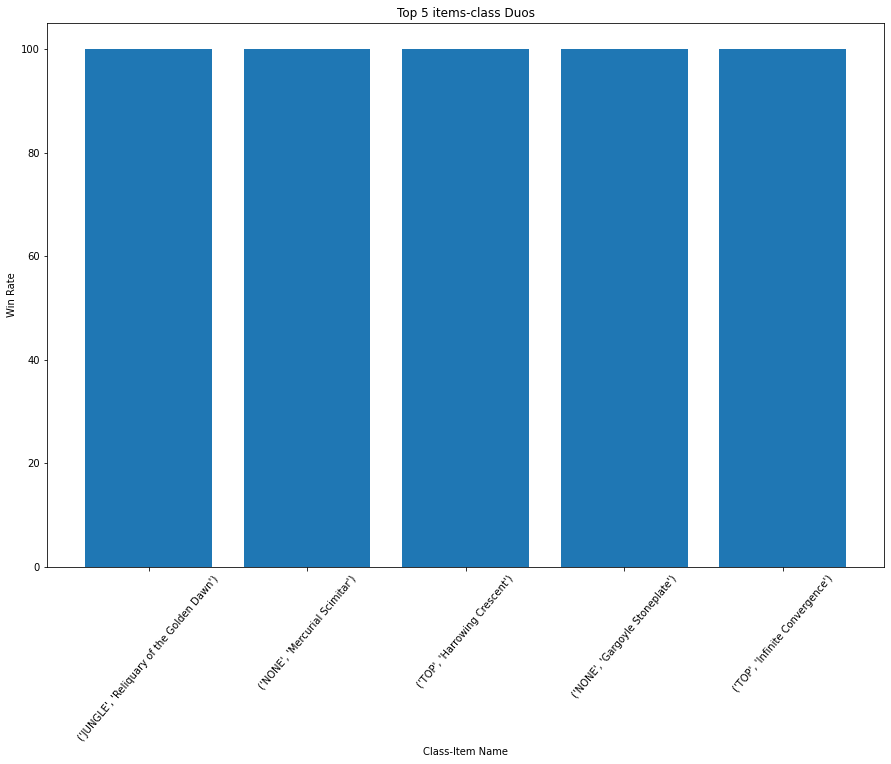

In [ ]:
a,b=zip(*top_items_class_duosss)
duos=[]
for i in a:
  duos.append(str(i))
plt.figure(figsize=(15, 10));
plt.xticks(rotation=50)
plt.title("Top 5 items-class Duos")
plt.xlabel('Class-Item Name')
plt.ylabel('Win Rate')
plt.bar(duos,b);

# Requirement 5


## Item suggestion:


In [ ]:
def items_suggestion_for_champion(champion_name):
    return champions_items_synergies.filter(lambda x: x[0][0] == champion_name).sortBy(lambda x: x[1], ascending = False).collect()

In [ ]:
"""
def items_suggestion_for_champion(champion_name):
    champion_items = all_champion_items_duos.filter(lambda x: x[0][0] == champion_name).sortBy(lambda x: x[1], ascending = False)
    itemsId_duos_list = [list(i) for i in champion_items.collect()]
    itemsName_duos = []
     
    for j in itemsId_duos_list:
       name = items_rdd.map(lambda x: x['data'][str(j[0][1])]['name'] ).collect()[0]
       itemsName_duos.append([tuple([j[0][0], name]), j[1]])
    
    return itemsName_duos
"""

In [ ]:
# Get the pick rate for each item name
itemsId_duos_list = [list(i) for i in champions_items_synergies.collect()]
itemsName_duos = []
for j in itemsId_duos_list:
  try:
    name = items_rdd.map(lambda x: x['data'][str(j[0][1])]['name'] ).collect()[0]
    itemsName_duos.append([tuple([j[0][0], name]), j[1]])
  except:
    pass

In [ ]:
items_suggestion_for_champion('Ekko')

[(('Ekko', 1054), 100.0),
 (('Ekko', 3193), 100.0),
 (('Ekko', 3040), 100.0),
 (('Ekko', 6675), 100.0),
 (('Ekko', 8020), 100.0),
 (('Ekko', 3153), 100.0),
 (('Ekko', 3850), 100.0),
 (('Ekko', 3143), 100.0),
 (('Ekko', 8001), 100.0),
 (('Ekko', 1035), 100.0),
 (('Ekko', 3133), 100.0),
 (('Ekko', 3001), 100.0),
 (('Ekko', 3139), 100.0),
 (('Ekko', 3078), 100.0),
 (('Ekko', 3033), 100.0),
 (('Ekko', 3094), 100.0),
 (('Ekko', 3400), 100.0),
 (('Ekko', 7011), 81.48),
 (('Ekko', 3041), 80.23),
 (('Ekko', 3075), 80.0),
 (('Ekko', 3066), 75.0),
 (('Ekko', 3140), 70.0),
 (('Ekko', 6672), 66.67),
 (('Ekko', 3009), 66.67),
 (('Ekko', 4644), 62.5),
 (('Ekko', 6655), 62.5),
 (('Ekko', 3158), 62.12),
 (('Ekko', 3089), 60.67),
 (('Ekko', 6653), 60.0),
 (('Ekko', 4632), 60.0),
 (('Ekko', 4637), 59.38),
 (('Ekko', 4630), 57.74),
 (('Ekko', 3082), 57.14),
 (('Ekko', 1033), 57.14),
 (('Ekko', 3135), 56.34),
 (('Ekko', 3115), 56.29),
 (('Ekko', 3047), 55.71),
 (('Ekko', 3116), 55.56),
 (('Ekko', 6665), 5

In [ ]:
items_suggestion_for_champion('Zac')

[(('Zac', 1035), 100.0),
 (('Zac', 7027), 100.0),
 (('Zac', 1036), 100.0),
 (('Zac', 6656), 100.0),
 (('Zac', 3803), 100.0),
 (('Zac', 3026), 100.0),
 (('Zac', 3057), 100.0),
 (('Zac', 1027), 100.0),
 (('Zac', 6653), 100.0),
 (('Zac', 7004), 100.0),
 (('Zac', 2139), 100.0),
 (('Zac', 4005), 100.0),
 (('Zac', 4643), 100.0),
 (('Zac', 7026), 100.0),
 (('Zac', 3053), 100.0),
 (('Zac', 3853), 100.0),
 (('Zac', 3748), 100.0),
 (('Zac', 2033), 87.5),
 (('Zac', 3100), 80.0),
 (('Zac', 3857), 80.0),
 (('Zac', 3041), 77.03),
 (('Zac', 1006), 76.92),
 (('Zac', 3024), 75.0),
 (('Zac', 3110), 73.33),
 (('Zac', 3191), 66.67),
 (('Zac', 3009), 66.67),
 (('Zac', 3850), 66.67),
 (('Zac', 6616), 66.67),
 (('Zac', 7005), 66.67),
 (('Zac', 3117), 66.67),
 (('Zac', 3801), 63.64),
 (('Zac', 4637), 63.43),
 (('Zac', 3082), 60.15),
 (('Zac', 3143), 59.39),
 (('Zac', 1082), 58.84),
 (('Zac', 3065), 57.74),
 (('Zac', 3001), 57.69),
 (('Zac', 2003), 57.14),
 (('Zac', 1101), 57.14),
 (('Zac', 8020), 57.14),
 (('

In [ ]:
items_suggestion_for_champion('Qiyana')

[(('Qiyana', 6631), 100.0),
 (('Qiyana', 3857), 100.0),
 (('Qiyana', 3157), 100.0),
 (('Qiyana', 6035), 100.0),
 (('Qiyana', 3033), 100.0),
 (('Qiyana', 3140), 100.0),
 (('Qiyana', 3153), 100.0),
 (('Qiyana', 6665), 100.0),
 (('Qiyana', 3864), 75.0),
 (('Qiyana', 3161), 74.29),
 (('Qiyana', 2420), 72.73),
 (('Qiyana', 6630), 71.43),
 (('Qiyana', 3004), 70.83),
 (('Qiyana', 1038), 69.23),
 (('Qiyana', 1018), 66.67),
 (('Qiyana', 3026), 63.16),
 (('Qiyana', 3009), 60.0),
 (('Qiyana', 3035), 59.43),
 (('Qiyana', 3123), 58.54),
 (('Qiyana', 6333), 57.79),
 (('Qiyana', 1037), 57.58),
 (('Qiyana', 3142), 56.2),
 (('Qiyana', 3071), 55.41),
 (('Qiyana', 3067), 55.0),
 (('Qiyana', 3814), 54.97),
 (('Qiyana', 6694), 54.05),
 (('Qiyana', 1033), 53.85),
 (('Qiyana', 3158), 53.25),
 (('Qiyana', 3074), 53.03),
 (('Qiyana', 1028), 52.17),
 (('Qiyana', 3042), 51.75),
 (('Qiyana', 6693), 51.59),
 (('Qiyana', 7000), 50.0),
 (('Qiyana', 6609), 50.0),
 (('Qiyana', 1101), 50.0),
 (('Qiyana', 3036), 50.0),


In [ ]:
items_suggestion_for_champion('Diana')

[(('Diana', 3074), 100.0),
 (('Diana', 3124), 100.0),
 (('Diana', 3042), 100.0),
 (('Diana', 3026), 100.0),
 (('Diana', 3802), 100.0),
 (('Diana', 3011), 100.0),
 (('Diana', 6667), 100.0),
 (('Diana', 3139), 100.0),
 (('Diana', 3850), 100.0),
 (('Diana', 4638), 100.0),
 (('Diana', 7010), 100.0),
 (('Diana', 3041), 90.41),
 (('Diana', 4644), 87.5),
 (('Diana', 7011), 72.73),
 (('Diana', 3100), 71.77),
 (('Diana', 3116), 71.43),
 (('Diana', 4629), 68.75),
 (('Diana', 8020), 67.65),
 (('Diana', 6656), 66.67),
 (('Diana', 7026), 66.67),
 (('Diana', 8001), 66.67),
 (('Diana', 4401), 63.64),
 (('Diana', 3089), 63.15),
 (('Diana', 3143), 61.54),
 (('Diana', 1082), 60.76),
 (('Diana', 6662), 60.0),
 (('Diana', 3140), 60.0),
 (('Diana', 3193), 60.0),
 (('Diana', 3211), 59.09),
 (('Diana', 3082), 58.82),
 (('Diana', 1102), 58.62),
 (('Diana', 4645), 58.58),
 (('Diana', 4633), 57.84),
 (('Diana', 1058), 57.79),
 (('Diana', 2420), 57.35),
 (('Diana', 3157), 56.21),
 (('Diana', 4637), 55.86),
 (('D

In [ ]:
items_suggestion_for_champion('Zed')

[(('Zed', 3400), 100.0),
 (('Zed', 2140), 100.0),
 (('Zed', 3855), 100.0),
 (('Zed', 6632), 100.0),
 (('Zed', 3089), 100.0),
 (('Zed', 2033), 100.0),
 (('Zed', 6673), 100.0),
 (('Zed', 3916), 100.0),
 (('Zed', 3051), 100.0),
 (('Zed', 3091), 100.0),
 (('Zed', 3004), 100.0),
 (('Zed', 3066), 100.0),
 (('Zed', 1026), 100.0),
 (('Zed', 3044), 100.0),
 (('Zed', 3181), 100.0),
 (('Zed', 2138), 100.0),
 (('Zed', 3115), 100.0),
 (('Zed', 7000), 94.12),
 (('Zed', 3143), 83.33),
 (('Zed', 3857), 80.0),
 (('Zed', 3508), 78.38),
 (('Zed', 2421), 76.47),
 (('Zed', 1038), 68.89),
 (('Zed', 6665), 66.67),
 (('Zed', 3046), 66.67),
 (('Zed', 2420), 65.0),
 (('Zed', 7001), 64.71),
 (('Zed', 3031), 63.64),
 (('Zed', 3026), 62.35),
 (('Zed', 3140), 61.9),
 (('Zed', 7002), 61.54),
 (('Zed', 3065), 60.0),
 (('Zed', 3814), 58.35),
 (('Zed', 6675), 57.14),
 (('Zed', 6696), 56.25),
 (('Zed', 3179), 55.66),
 (('Zed', 3033), 55.56),
 (('Zed', 3071), 55.02),
 (('Zed', 3009), 54.55),
 (('Zed', 6695), 54.55),
 (('

In [ ]:
items_suggestion_for_champion('Caitlyn')

[(('Caitlyn', 3053), 100.0),
 (('Caitlyn', 2423), 100.0),
 (('Caitlyn', 3067), 100.0),
 (('Caitlyn', 4628), 100.0),
 (('Caitlyn', 3857), 100.0),
 (('Caitlyn', 1082), 100.0),
 (('Caitlyn', 3020), 100.0),
 (('Caitlyn', 7001), 100.0),
 (('Caitlyn', 3068), 100.0),
 (('Caitlyn', 3100), 100.0),
 (('Caitlyn', 3742), 100.0),
 (('Caitlyn', 4636), 100.0),
 (('Caitlyn', 3179), 100.0),
 (('Caitlyn', 3142), 75.0),
 (('Caitlyn', 6693), 75.0),
 (('Caitlyn', 3084), 75.0),
 (('Caitlyn', 7007), 73.68),
 (('Caitlyn', 3814), 69.23),
 (('Caitlyn', 6694), 68.75),
 (('Caitlyn', 3026), 67.55),
 (('Caitlyn', 3044), 66.67),
 (('Caitlyn', 3071), 66.67),
 (('Caitlyn', 3091), 66.67),
 (('Caitlyn', 3400), 66.67),
 (('Caitlyn', 3085), 65.0),
 (('Caitlyn', 3748), 62.5),
 (('Caitlyn', 1029), 60.53),
 (('Caitlyn', 2140), 60.0),
 (('Caitlyn', 3051), 60.0),
 (('Caitlyn', 3143), 60.0),
 (('Caitlyn', 3072), 59.71),
 (('Caitlyn', 3070), 58.62),
 (('Caitlyn', 3031), 58.57),
 (('Caitlyn', 3111), 58.33),
 (('Caitlyn', 3042), 5

In [ ]:
items_suggestion_for_champion('Irelia')

[(('Irelia', 3095), 100.0),
 (('Irelia', 6695), 100.0),
 (('Irelia', 3742), 100.0),
 (('Irelia', 3031), 100.0),
 (('Irelia', 3801), 100.0),
 (('Irelia', 3046), 100.0),
 (('Irelia', 3400), 100.0),
 (('Irelia', 7025), 100.0),
 (('Irelia', 6696), 100.0),
 (('Irelia', 3121), 100.0),
 (('Irelia', 6693), 100.0),
 (('Irelia', 3004), 100.0),
 (('Irelia', 3066), 100.0),
 (('Irelia', 3083), 100.0),
 (('Irelia', 6676), 100.0),
 (('Irelia', 3161), 85.71),
 (('Irelia', 6694), 80.0),
 (('Irelia', 3072), 72.73),
 (('Irelia', 3748), 68.66),
 (('Irelia', 3140), 67.86),
 (('Irelia', 3124), 66.67),
 (('Irelia', 3181), 66.67),
 (('Irelia', 3857), 66.67),
 (('Irelia', 7015), 66.67),
 (('Irelia', 3139), 66.67),
 (('Irelia', 3026), 64.99),
 (('Irelia', 1038), 64.47),
 (('Irelia', 3053), 64.06),
 (('Irelia', 3193), 63.64),
 (('Irelia', 1057), 63.16),
 (('Irelia', 6672), 62.5),
 (('Irelia', 2422), 61.54),
 (('Irelia', 3078), 60.87),
 (('Irelia', 3071), 60.87),
 (('Irelia', 3065), 60.47),
 (('Irelia', 3042), 60

In [ ]:
items_suggestion_for_champion('Ezreal')

[(('Ezreal', 1102), 100.0),
 (('Ezreal', 3193), 100.0),
 (('Ezreal', 1103), 100.0),
 (('Ezreal', 3862), 100.0),
 (('Ezreal', 4635), 100.0),
 (('Ezreal', 6677), 100.0),
 (('Ezreal', 4636), 100.0),
 (('Ezreal', 3863), 100.0),
 (('Ezreal', 3041), 100.0),
 (('Ezreal', 3124), 100.0),
 (('Ezreal', 7001), 100.0),
 (('Ezreal', 7024), 100.0),
 (('Ezreal', 3053), 100.0),
 (('Ezreal', 3143), 100.0),
 (('Ezreal', 7017), 94.12),
 (('Ezreal', 6035), 84.21),
 (('Ezreal', 3046), 83.33),
 (('Ezreal', 3400), 80.0),
 (('Ezreal', 4630), 77.78),
 (('Ezreal', 3211), 75.0),
 (('Ezreal', 1011), 72.22),
 (('Ezreal', 7002), 71.43),
 (('Ezreal', 3814), 71.43),
 (('Ezreal', 7018), 70.59),
 (('Ezreal', 2420), 69.35),
 (('Ezreal', 1052), 68.97),
 (('Ezreal', 4645), 68.97),
 (('Ezreal', 6676), 66.67),
 (('Ezreal', 3094), 66.67),
 (('Ezreal', 7005), 66.67),
 (('Ezreal', 6653), 66.67),
 (('Ezreal', 4644), 64.89),
 (('Ezreal', 3086), 63.64),
 (('Ezreal', 3157), 62.96),
 (('Ezreal', 1026), 60.0),
 (('Ezreal', 3065), 60.

In [ ]:
items_suggestion_for_champion('Jax')

# Extra Requirement

### 1.   Best lanes for champions: 







In [ ]:
def all_champion_lanes_duos(matches):
  """
  This function finds all possible champions items duos
  """
  champion_lanes= []
  champions_lanes_duos = []

  # Get all participants in all matches
  participants = matches["info"]["participants"]

  # Get the champion names of all participants
  for i in participants:
    champion_lanes.append(tuple([ i["championName"], i["lane"]] ))

  # Form all possible duos between champions and items
  for i in champion_lanes:
      champions_lanes_duos.append((i, 1))
  
  return champions_lanes_duos

In [ ]:
def winning_champion_lanes_duos(matches):
  """
  This function finds winning duos only
  """
  winning_champion_lanes= []
  winning_champions_lanes_duos = []
  # Get all participants in all matches
  participants = matches["info"]["participants"]
  # Get the champion names of all winning participants
  for i in participants:
    if i["win"]:
      winning_champion_lanes.append(tuple([ i["championName"], i["lane"]] ))

  # Form all possible duos between winning champions and items
  for i in winning_champion_lanes:
      winning_champions_lanes_duos.append((i, 1))
  
  return winning_champions_lanes_duos

In [ ]:
# Get all possible champion items duos from all matches
all_champion_lanes_duos = ranked_matches_rdd.map(all_champion_lanes_duos)

# Get the number of count of each duos champions
all_champion_lanes_duos_count = all_champion_lanes_duos.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get the winning champion items duos
winning_champion_lanes_duos = ranked_matches_rdd.map(winning_champion_lanes_duos)

# Get the count of each winning duos
winning_champion_lanes_duos_count = winning_champion_lanes_duos.flatMap(lambda x: x).reduceByKey(lambda a, b: a + b)

# Get champion synergies or duos
champions_items_synergies = winning_champion_lanes_duos_count.join(all_champion_lanes_duos_count).mapValues(lambda x: round(x[0] *100 / x[1], 2))

In [ ]:
all_champion_lanes_duos_count.take(50)

[(('Vayne', 'JUNGLE'), 200),
 (('Fiora', 'TOP'), 3243),
 (('DrMundo', 'NONE'), 505),
 (('Warwick', 'NONE'), 507),
 (('Neeko', 'MIDDLE'), 773),
 (('Jax', 'MIDDLE'), 209),
 (('Taliyah', 'BOTTOM'), 90),
 (('AurelionSol', 'TOP'), 19),
 (('Lillia', 'JUNGLE'), 2033),
 (('Kindred', 'JUNGLE'), 2443),
 (('LeeSin', 'NONE'), 400),
 (('Urgot', 'TOP'), 1332),
 (('Diana', 'MIDDLE'), 1259),
 (('Ekko', 'NONE'), 474),
 (('Xayah', 'BOTTOM'), 1612),
 (('Nasus', 'BOTTOM'), 91),
 (('Jayce', 'NONE'), 103),
 (('Blitzcrank', 'MIDDLE'), 394),
 (('Volibear', 'NONE'), 269),
 (('Zyra', 'MIDDLE'), 202),
 (('TwistedFate', 'NONE'), 75),
 (('Evelynn', 'NONE'), 180),
 (('Zac', 'NONE'), 216),
 (('Varus', 'TOP'), 178),
 (('Hecarim', 'BOTTOM'), 6),
 (('MasterYi', 'JUNGLE'), 5022),
 (('Samira', 'BOTTOM'), 4483),
 (('Malphite', 'NONE'), 223),
 (('Kaisa', 'TOP'), 132),
 (('Jax', 'NONE'), 350),
 (('Zed', 'NONE'), 573),
 (('Zilean', 'MIDDLE'), 248),
 (('Tristana', 'MIDDLE'), 746),
 (('Veigar', 'TOP'), 190),
 (('Katarina', 'TO

In [ ]:
winning_champion_lanes_duos_count.take(50)

[(('Vayne', 'JUNGLE'), 95),
 (('Fiora', 'TOP'), 1584),
 (('DrMundo', 'NONE'), 246),
 (('Warwick', 'NONE'), 293),
 (('Neeko', 'MIDDLE'), 392),
 (('Jax', 'MIDDLE'), 103),
 (('Taliyah', 'BOTTOM'), 51),
 (('AurelionSol', 'TOP'), 10),
 (('Lillia', 'JUNGLE'), 1067),
 (('Kindred', 'JUNGLE'), 1181),
 (('LeeSin', 'NONE'), 185),
 (('Ekko', 'NONE'), 255),
 (('Diana', 'MIDDLE'), 650),
 (('Xayah', 'BOTTOM'), 767),
 (('Volibear', 'NONE'), 141),
 (('Blitzcrank', 'MIDDLE'), 183),
 (('Urgot', 'TOP'), 672),
 (('Zyra', 'MIDDLE'), 119),
 (('Evelynn', 'NONE'), 88),
 (('Jayce', 'NONE'), 48),
 (('Varus', 'TOP'), 99),
 (('TwistedFate', 'NONE'), 29),
 (('Zac', 'NONE'), 116),
 (('Nasus', 'BOTTOM'), 37),
 (('Hecarim', 'BOTTOM'), 3),
 (('MasterYi', 'JUNGLE'), 2566),
 (('Samira', 'BOTTOM'), 2305),
 (('Malphite', 'NONE'), 123),
 (('Kaisa', 'TOP'), 76),
 (('Jax', 'NONE'), 168),
 (('Zed', 'NONE'), 284),
 (('Zilean', 'MIDDLE'), 129),
 (('Veigar', 'TOP'), 109),
 (('Katarina', 'TOP'), 154),
 (('Annie', 'TOP'), 32),
 (('

In [ ]:
champions_items_synergies.take(50)

[(('Vayne', 'JUNGLE'), 47.5),
 (('Fiora', 'TOP'), 48.84),
 (('DrMundo', 'NONE'), 48.71),
 (('Warwick', 'NONE'), 57.79),
 (('Neeko', 'MIDDLE'), 50.71),
 (('Jax', 'MIDDLE'), 49.28),
 (('Taliyah', 'BOTTOM'), 56.67),
 (('AurelionSol', 'TOP'), 52.63),
 (('Lillia', 'JUNGLE'), 52.48),
 (('Kindred', 'JUNGLE'), 48.34),
 (('LeeSin', 'NONE'), 46.25),
 (('Ekko', 'NONE'), 53.8),
 (('Diana', 'MIDDLE'), 51.63),
 (('Xayah', 'BOTTOM'), 47.58),
 (('Volibear', 'NONE'), 52.42),
 (('Blitzcrank', 'MIDDLE'), 46.45),
 (('Urgot', 'TOP'), 50.45),
 (('Zyra', 'MIDDLE'), 58.91),
 (('Evelynn', 'NONE'), 48.89),
 (('Jayce', 'NONE'), 46.6),
 (('Varus', 'TOP'), 55.62),
 (('TwistedFate', 'NONE'), 38.67),
 (('Zac', 'NONE'), 53.7),
 (('Nasus', 'BOTTOM'), 40.66),
 (('Hecarim', 'BOTTOM'), 50.0),
 (('MasterYi', 'JUNGLE'), 51.1),
 (('Samira', 'BOTTOM'), 51.42),
 (('Malphite', 'NONE'), 55.16),
 (('Kaisa', 'TOP'), 57.58),
 (('Jax', 'NONE'), 48.0),
 (('Zed', 'NONE'), 49.56),
 (('Zilean', 'MIDDLE'), 52.02),
 (('Veigar', 'TOP'), 5

In [ ]:
with open("/content/drive/MyDrive/BigData/Output/lanes_champions_duos", "w") as file:
    file.write(str(champions_items_synergies.collect()))

## 2. Best Lane for certain champion

In [ ]:
def lanes_suggestion_for_champion(champion_name):
    return champions_items_synergies.filter(lambda x: x[0][0] == champion_name).sortBy(lambda x: x[1], ascending = False).collect()

In [ ]:
a5 = items_suggestion_for_champion('Diana')

In [ ]:
print(a5)

[(('Diana', 'TOP'), 59.06), (('Diana', 'NONE'), 55.65), (('Diana', 'MIDDLE'), 51.63), (('Diana', 'JUNGLE'), 50.89), (('Diana', 'BOTTOM'), 35.9)]


In [ ]:
a5 = [(('Diana', 'TOP'), 59.06), (('Diana', 'MIDDLE'), 51.63), (('Diana', 'JUNGLE'), 50.89), (('Diana', 'BOTTOM'), 35.9)]

In [ ]:
b5 = items_suggestion_for_champion('Irelia')

In [ ]:
print(b5)

[(('Irelia', 'BOTTOM'), 51.79), (('Irelia', 'NONE'), 51.56), (('Irelia', 'MIDDLE'), 49.91), (('Irelia', 'JUNGLE'), 48.36), (('Irelia', 'TOP'), 48.15)]


In [ ]:
b5 = [(('Irelia', 'BOTTOM'), 51.79), (('Irelia', 'MIDDLE'), 49.91), (('Irelia', 'JUNGLE'), 48.36), (('Irelia', 'TOP'), 48.15)]

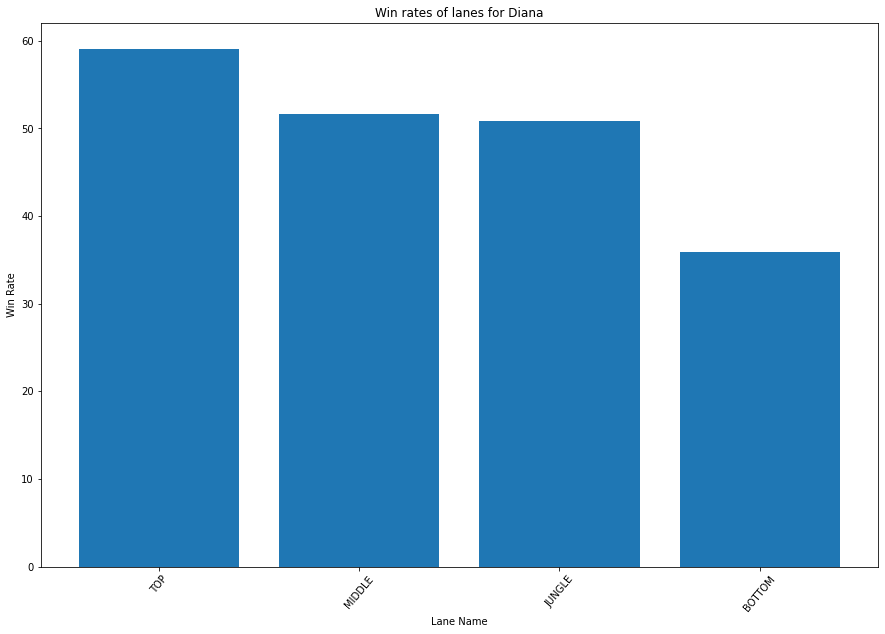

In [ ]:
a,b=zip(*list(a5))
duos=[]
for i in a:
    duos.append(str(i[1]))
plt.figure(figsize=(15, 10));
plt.xticks(rotation=50)
plt.title("Win rates of lanes for Diana")
plt.xlabel('Lane Name')
plt.ylabel('Win Rate')
plt.bar(duos,b);

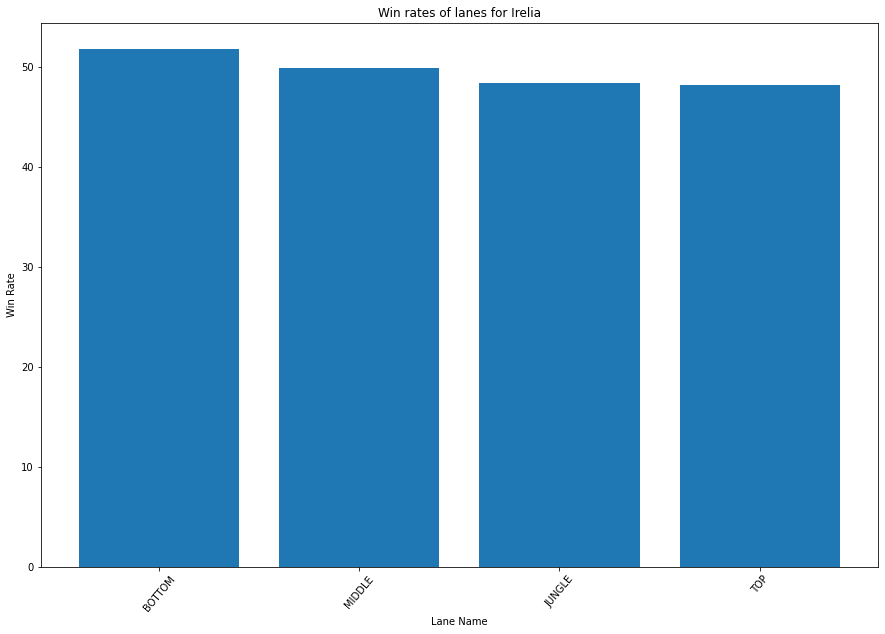

In [ ]:
a,b=zip(*list(b5))
duos=[]
for i in a:
  duos.append(str(i[1]))
plt.figure(figsize=(15, 10));
plt.xticks(rotation=50)
plt.title("Win rates of lanes for Irelia")
plt.xlabel('Lane Name')
plt.ylabel('Win Rate')
plt.bar(duos,b);